# Step response analyzer
---
Takes step response data, and calculates the DC gain and time constant for a second order system.

Step frequency = 0.2Hz

Amplitude = 350

Trun-on command = 65

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import data from csv file, create headers for each column based on the LabView VI.
df = pd.read_csv('square_0p2_Hz.csv', index_col=False, skiprows=26, delimiter='\t',
                names=['time_s', 'cmd_sig', 'ang_deg', 'vel_deg_s', 'amp', 'freq_hz',
                         'sin0_or_sqr1'])
df.head()

,time_s,cmd_sig,ang_deg,vel_deg_s,amp,freq_hz,sin0_or_sqr1
0,22.7014,-350.0,574.050118,-346.386507,350.0,0.2,1.0
1,22.7019,-350.0,573.877049,-346.409313,350.0,0.2,1.0
2,22.7024,-350.0,573.703566,-346.414443,350.0,0.2,1.0
3,22.7029,-350.0,573.530138,-346.409118,350.0,0.2,1.0
4,22.7034,-350.0,573.356804,-346.385529,350.0,0.2,1.0


<Axes: xlabel='time_s'>

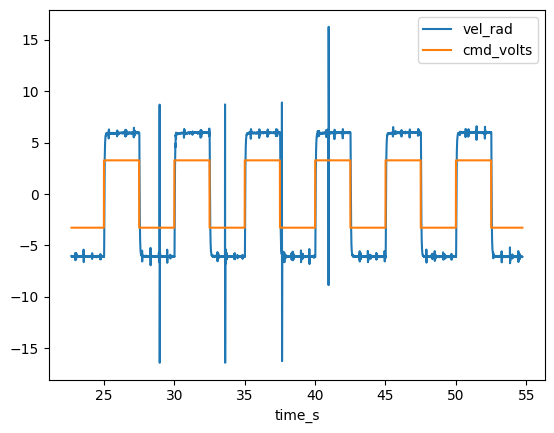

In [3]:
# Create new columns for 

df.insert(3, "ang_rad", df["ang_deg"].to_numpy()*np.pi/180, True)   # Rotation angle in Radians
df.insert(7, 'freq_rad', df['freq_hz'].to_numpy()*2*np.pi, True)    # Frequency in radians/sec for use in least squares fit
df.insert(5, 'vel_rad', np.deg2rad(df['vel_deg_s'].to_numpy()), True)   # Platen angular velocity in radians/sec
df.insert(2, 'cmd_volts', (df['cmd_sig'].to_numpy()*(1023+65)/1023)*9/1023)   # Calculate true command voltage by adding turn-on
                                                                    # command offset dividing by PWM resolution and
                                                                    # multiplying by DC power supply voltage (9V)
df.plot(x="time_s", y=[ "vel_rad", 'cmd_volts'])

Text(0, 0.5, 'Platen Velocity (rad/s)')

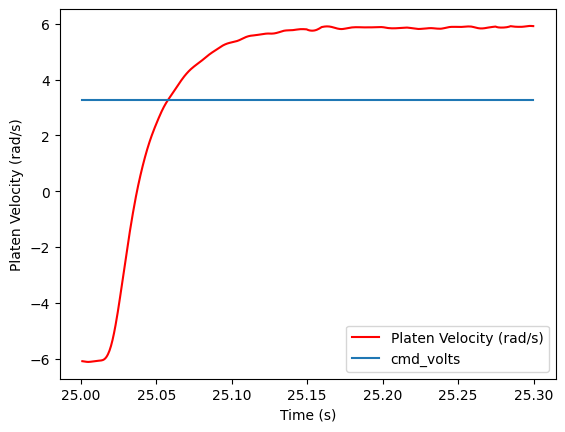

In [4]:
# Isolate positive steps
df = df[df['time_s'] <= 25.3]
first_step = df[df['cmd_volts'] > 0]
ax1 = first_step.plot( x="time_s", y="vel_rad", color='r', label='Platen Velocity (rad/s)')
ax2 = first_step.plot(x='time_s', y = 'cmd_volts', ax=ax1)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Platen Velocity (rad/s)")

0.014009000000001492 seconds


Text(0.5, 0, 'Time (s)')

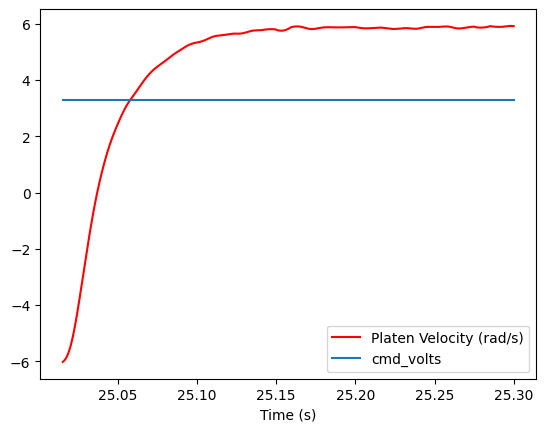

In [5]:
# Remove time delay
t0 = first_step['time_s'].min()
rise_start_time =  25.015 # Iteratively found time for finding the start of the rise
first_step = first_step[first_step['time_s'] > rise_start_time] # Remove the system time delay and isolate first step

# Find system time delay
time_delay = 25.015 - t0
print(f'{time_delay} seconds')

ax1 = first_step.plot(x="time_s", y="vel_rad", color='r', label='Platen Velocity (rad/s)')
ax2 = first_step.plot(x='time_s', y='cmd_volts', ax=ax1)
ax1.set_xlabel("Time (s)")


In [6]:
low_vel = df[df['cmd_volts'] < 0] # Create dataframe of all low voltage data
low_vel = low_vel['vel_rad'].mean()    # Find mean velocity at low voltage steady state
high_vel = df[df['cmd_volts'] > 0]  # Create dataframe of all high voltage data 
high_vel = high_vel['vel_rad'].max()    # Find maximum velocity at high voltage state to represent high steady state velocity
print(low_vel, high_vel)

-6.071252718639713 5.922287485809015


In [7]:
high_volts = df['cmd_volts'].max()  # Find max voltage
low_volts = df['cmd_volts'].min()   # Find min voltage
print(high_volts, low_volts)

3.274825637894411 -3.274825637894411


In [8]:
k_dc_gain = (high_vel - low_vel)/(high_volts - low_volts) # Change in velocity over change in voltage for dc gain
rise = low_vel + 0.632 * (high_vel - low_vel)   # 63.2% of the steady state value
rise_time = first_step[first_step['vel_rad'] > rise] # Dataframe of data after 63.2% of steady state value is reached
time_constant = rise_time['time_s'].min() - first_step['time_s'].min()
print(f'DC Gain = {k_dc_gain} rad/sec*Volt \nTime constant: {time_constant} seconds')

DC Gain = 1.8311723326070148 rad/sec*Volt 
Time constant: 0.02900399999999692 seconds


In [9]:
delayed_time_const = time_constant + time_delay
print(f'Delayed Time Constant: {delayed_time_const} seconds')

Delayed Time Constant: 0.043012999999998414 seconds


# Results
---
First order transfer function approximation: 

$$ T(s) = \frac{k_{DC}}{\tau s + 1} =  \frac{1.831172}{0.029003s+1} $$

Time delayed transfer function: 

$$ T(s) = \frac{1.831172}{0.043012 s + 1} $$